# EFM Particle Properties: Deriving Spin Analogues\n\nThis notebook investigates the emergence of spin-like properties (angular momentum) from dynamic eholokon (soliton) structures within the Ehokolo Fluxon Model (EFM). Building on the successful formation of a stable, massive scalar soliton, we explore if stable, *rotating* scalar eholokon solutions can exist and possess quantifiable, potentially quantized, angular momentum.\n\n## Objectives\n- Simulate the EFM NLKG equation for a real scalar field with initial conditions designed to induce rotational motion.\n- Employ absorbing boundary conditions to allow the system to relax to a potentially stable, rotating soliton state.\n- Define and calculate a fluxonic current density \(J_\\phi \\sim (\\partial\\phi/\\partial t)\\nabla\\phi\) and its associated angular momentum \(L = \\int \\mathbf{r} \\times \\mathbf{J}_\\phi dV\).\n- Track the evolution of Max\(|\\phi|\), total energy, mass integral, and total angular momentum.\n- Determine if a stable, rotating soliton forms with persistent, non-zero angular momentum.\n\n## Link to EFM/RST First Principles\nIn Reciprocal System Theory, intrinsic properties like spin and charge are viewed as different types or dimensions of motion. This simulation attempts to model a rotational aspect of scalar motion to see if a stable, spin-like angular momentum can be self-sustained by an eholokon.

In [2]:
# Set environment variable to reduce memory fragmentation
import os
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

# Clear GPU memory
import torch
if torch.cuda.is_available():
    torch.cuda.empty_cache()
import gc
gc.collect()

print(f"PyTorch version: {torch.__version__}")
!nvidia-smi

import numpy as np
from tqdm.notebook import tqdm
import psutil
import time
from datetime import datetime
import torch.nn.functional as F
import matplotlib.pyplot as plt
import glob  # Added for checkpoint loading in results cell

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if device.type == "cuda":
    print(f"GPU VRAM: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
print(f"System RAM: {psutil.virtual_memory().total / 1e9:.2f} GB")

from google.colab import drive
drive.mount('/content/drive')
checkpoint_path_spin = '/content/drive/MyDrive/EFM_checkpoints/SpinChargeGen/4H25k'
data_path_spin = '/content/drive/MyDrive/EFM_data/SpinChargeGen/4H25k'
os.makedirs(checkpoint_path_spin, exist_ok=True)
os.makedirs(data_path_spin, exist_ok=True)

PyTorch version: 2.6.0+cu124
Tue May 13 21:07:09 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   31C    P0             45W /  400W |       5MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+------------------

## Simulation Setup: Inducing Rotation

Parameters are similar to the mass generation simulation, but initial conditions will include a rotational component.

In [3]:
# === Simulation Parameters for Spin Analogue Generation ===
N_sim_sc = 400  # Grid size (N_sim x N_sim x N_sim) - Keep moderate for initial tests
T_sim_sc = 25000 # Total simulation steps

config_sc = {}
config_sc['N'] = N_sim_sc

# Physical Scale (Angstroms)
L_angstroms_sc = 50.0
config_sc['L_phys_meters'] = L_angstroms_sc * 1e-10
config_sc['dx_phys_meters'] = config_sc['L_phys_meters'] / config_sc['N']
c_si = 3e8

# Simulation Units (dx_sim = 1, c_sim = 1)
config_sc['dx_sim'] = 1.0
config_sc['c_sim'] = 1.0
config_sc['L_sim'] = float(config_sc['N']) * config_sc['dx_sim']

config_sc['dt_cfl_factor'] = 0.05
config_sc['dt_sim'] = config_sc['dt_cfl_factor'] * config_sc['dx_sim'] / config_sc['c_sim']

config_sc['T_steps'] = T_sim_sc
config_sc['chunk_size'] = 50  # N_sim_sc / 4

config_sc['boundary_width_factor'] = 0.15
config_sc['damping_strength'] = 0.2

# NLKG Potential Coefficients (Same as successful mass gen run)
config_sc['m_sq_param'] = 1.0
config_sc['g_param']    = -0.1
config_sc['eta_param']  = 0.01

config_sc['k_mass_coupling_sim'] = 0.01 # For mass integral tracking

# Initial Pulse & Rotation Parameters
config_sc['A0_initial_pulse'] = 12.0
config_sc['w0_initial_pulse'] = 5.0 * config_sc['dx_sim']
config_sc['initial_rotation_strength'] = 0.5 # Strength of initial phi_dot for rotation

# --- Log parameters ---
print(f"--- Spin/Charge Analogue Simulation Parameters (N={config_sc['N']}, T={config_sc['T_steps']}) ---")
for key, value in config_sc.items():
    if isinstance(value, float): print(f"{key}: {value:.2e}")
    else: print(f"{key}: {value}")

--- Spin/Charge Analogue Simulation Parameters (N=400, T=25000) ---
N: 400
L_phys_meters: 5.00e-09
dx_phys_meters: 1.25e-11
dx_sim: 1.00e+00
c_sim: 1.00e+00
L_sim: 4.00e+02
dt_cfl_factor: 5.00e-02
dt_sim: 5.00e-02
T_steps: 25000
chunk_size: 50
boundary_width_factor: 1.50e-01
damping_strength: 2.00e-01
m_sq_param: 1.00e+00
g_param: -1.00e-01
eta_param: 1.00e-02
k_mass_coupling_sim: 1.00e-02
A0_initial_pulse: 1.20e+01
w0_initial_pulse: 5.00e+00
initial_rotation_strength: 5.00e-01


## Core Simulation Functions

Reusing Laplacian, RK4, Energy, Mass Integral, and Absorbing Boundary functions from the Mass Generation notebook. **New functions will be needed for Fluxonic Current and Angular Momentum calculation.**

In [4]:
# --- Reused Functions (ensure they are defined as in Mass Gen notebook) ---
# potential_derivative_mass(phi, m_sq, g, eta)
# conv_laplacian_mass(phi, dx, device)
# nlkg_derivative_mass(phi, phi_dot, m_sq, g, eta, dx, c_sq) -> becomes nlkg_derivative_sc
# create_absorbing_mask(N, width_factor, strength, device)
# update_phi_rk4_mass_chunked(...) -> becomes update_phi_rk4_sc_chunked(...)
# compute_total_energy_sim(phi_cpu, phi_dot_cpu, ...) -> becomes compute_total_energy_sc(...)
# compute_mass_integral_sim(phi_cpu, ...) -> becomes compute_mass_integral_sc(...)

# --- Copied Functions from Mass Generation Notebook for Self-Containment ---
@torch.jit.script
def potential_derivative_mass(phi, m_sq: float, g: float, eta: float):
    return m_sq * phi + g * torch.pow(phi, 3) + eta * torch.pow(phi, 5)

@torch.jit.script
def conv_laplacian_mass(phi, dx: float, device: torch.device):
    stencil = torch.tensor([[[0, 0, 0], [0, 1, 0], [0, 0, 0]],
                            [[0, 1, 0], [1, -6, 1], [0, 1, 0]],
                            [[0, 0, 0], [0, 1, 0], [0, 0, 0]]],
                           dtype=torch.float32, device=device)
    stencil /= (dx**2)
    stencil = stencil.view(1, 1, 3, 3, 3)
    phi_reshaped = phi.view(1, 1, phi.shape[0], phi.shape[1], phi.shape[2])
    phi_padded = F.pad(phi_reshaped, (1, 1, 1, 1, 1, 1), mode='replicate')
    laplacian = F.conv3d(phi_padded, stencil, padding=0)
    return laplacian.view(phi.shape[0], phi.shape[1], phi.shape[2])

@torch.jit.script
def create_absorbing_mask(N: int, width_factor: float, strength: float, device: torch.device):
    mask = torch.ones((N, N, N), device=device, dtype=torch.float32)
    boundary_width = int(N * width_factor)
    if boundary_width == 0: return mask
    for i_mask in range(boundary_width):
        damp_val = strength * (torch.cos(i_mask * torch.pi / (2 * boundary_width)))**2
        s = 1.0 - damp_val
        mask[i_mask, :, :] *= s; mask[-(i_mask + 1), :, :] *= s
        mask[:, i_mask, :] *= s; mask[:, -(i_mask + 1), :] *= s
        mask[:, :, i_mask] *= s; mask[:, :, -(i_mask + 1)] *= s
    return mask.clamp(0,1)

def compute_total_energy_sim(phi_cpu, phi_dot_cpu, m_sq: float, g: float, eta: float,
                             chunk_size: int, dx: float, c_sq: float, device: torch.device):
    total_energy_val = 0.0
    N_grid = phi_cpu.shape[0]
    vol_element = dx**3
    for i in range(0, N_grid, chunk_size):
        chunk_slice = slice(i, min(i + chunk_size, N_grid))
        phi_chunk = phi_cpu[chunk_slice].to(device)
        phi_dot_chunk = phi_dot_cpu[chunk_slice].to(device)
        with torch.no_grad():
            if torch.any(torch.isinf(phi_chunk)) or torch.any(torch.isnan(phi_chunk)) or \
               torch.any(torch.isinf(phi_dot_chunk)) or torch.any(torch.isnan(phi_dot_chunk)):
                return float('nan')
            if phi_chunk.dim() != 3:
                raise ValueError(f"Expected phi_chunk to be 3D, got {phi_chunk.dim()}D with shape {phi_chunk.shape}")
            kinetic_density = 0.5 * torch.pow(phi_dot_chunk, 2)
            potential_density = 0.5 * m_sq * torch.pow(phi_chunk, 2) + \
                               (g / 4.0) * torch.pow(phi_chunk, 4) + \
                               (eta / 6.0) * torch.pow(phi_chunk, 6)
            gradient_sq_sum_density = torch.zeros_like(phi_chunk)
            for d_dim in range(3):
                pad_shape = list(phi_chunk.shape)
                pad_shape[d_dim] += 2
                phi_padded = torch.zeros(pad_shape, device=device, dtype=phi_chunk.dtype)
                if d_dim == 0:
                    phi_padded[1:-1, :, :] = phi_chunk
                    phi_padded[0, :, :] = phi_chunk[0, :, :]
                    phi_padded[-1, :, :] = phi_chunk[-1, :, :]
                elif d_dim == 1:
                    phi_padded[:, 1:-1, :] = phi_chunk
                    phi_padded[:, 0, :] = phi_chunk[:, 0, :]
                    phi_padded[:, -1, :] = phi_chunk[:, -1, :]
                else:
                    phi_padded[:, :, 1:-1] = phi_chunk
                    phi_padded[:, :, 0] = phi_chunk[:, :, 0]
                    phi_padded[:, :, -1] = phi_chunk[:, :, -1]
                slice_fwd = [slice(None)]*3; slice_fwd[d_dim] = slice(2, None)
                slice_bwd = [slice(None)]*3; slice_bwd[d_dim] = slice(0, -2)
                grad_d = (phi_padded[tuple(slice_fwd)] - phi_padded[tuple(slice_bwd)]) / (2 * dx)
                gradient_sq_sum_density += torch.pow(grad_d, 2)
                del phi_padded, grad_d
            gradient_density = 0.5 * c_sq * gradient_sq_sum_density
            chunk_energy = torch.sum(kinetic_density + potential_density + gradient_density).item() * vol_element
            if np.isnan(chunk_energy) or np.isinf(chunk_energy):
                return float('nan')
            total_energy_val += chunk_energy
        del phi_chunk, phi_dot_chunk, kinetic_density, potential_density, gradient_sq_sum_density, gradient_density
        if device.type == 'cuda': torch.cuda.empty_cache()
        gc.collect()
    return total_energy_val

def compute_mass_integral_sim(phi_cpu, chunk_size: int, dx: float, device: torch.device):
    mass_int_val = 0.0
    N_grid = phi_cpu.shape[0]
    vol_element = dx**3
    for i in range(0, N_grid, chunk_size):
        chunk_slice = slice(i, min(i + chunk_size, N_grid))
        phi_chunk = phi_cpu[chunk_slice].to(device)
        with torch.no_grad():
            if torch.any(torch.isinf(phi_chunk)) or torch.any(torch.isnan(phi_chunk)):
                return float('nan')
            mass_int_val += torch.sum(torch.pow(phi_chunk, 2)).item() * vol_element
        del phi_chunk
        if device.type == 'cuda': torch.cuda.empty_cache()
        gc.collect()
    return mass_int_val

# --- NLKG Derivative (same potential, just renaming for clarity) ---
@torch.jit.script
def nlkg_derivative_sc(phi, phi_dot, m_sq: float, g: float, eta: float, dx: float, c_sq: float):
    lap = conv_laplacian_mass(phi, dx, phi.device) # Reuse existing laplacian
    dv_dphi = potential_derivative_mass(phi, m_sq, g, eta) # Reuse existing potential deriv
    phi_ddot = c_sq * lap - dv_dphi
    return phi_dot, phi_ddot

# --- RK4 Update (same logic, uses nlkg_derivative_sc) ---
def update_phi_rk4_sc_chunked(phi_cpu, phi_dot_cpu, dt: float,
                              m_sq: float, g: float, eta: float,
                              damping_mask_cpu, chunk_size: int, dx: float, c_sq: float, device: torch.device):
    phi_new_cpu = torch.empty_like(phi_cpu)
    phi_dot_new_cpu = torch.empty_like(phi_dot_cpu)
    N_grid = phi_cpu.shape[0]
    for i in range(0, N_grid, chunk_size):
        chunk = slice(i, min(i + chunk_size, N_grid))
        phi_chunk = phi_cpu[chunk].to(device)
        phi_dot_chunk = phi_dot_cpu[chunk].to(device)
        with torch.no_grad():
            k1_v, k1_a = nlkg_derivative_sc(phi_chunk, phi_dot_chunk, m_sq, g, eta, dx, c_sq)
            k2_v, k2_a = nlkg_derivative_sc(phi_chunk + 0.5 * dt * k1_v, phi_dot_chunk + 0.5 * dt * k1_a, m_sq, g, eta, dx, c_sq)
            k3_v, k3_a = nlkg_derivative_sc(phi_chunk + 0.5 * dt * k2_v, phi_dot_chunk + 0.5 * dt * k2_a, m_sq, g, eta, dx, c_sq)
            k4_v, k4_a = nlkg_derivative_sc(phi_chunk + dt * k3_v, phi_dot_chunk + dt * k3_a, m_sq, g, eta, dx, c_sq)
            phi_new_chunk_gpu = phi_chunk + (dt / 6.0) * (k1_v + 2 * k2_v + 2 * k3_v + k4_v)
            phi_dot_new_chunk_gpu = phi_dot_chunk + (dt / 6.0) * (k1_a + 2 * k2_a + 2 * k3_a + k4_a)
            phi_dot_new_chunk_gpu *= damping_mask_cpu[chunk].to(device)
        phi_new_cpu[chunk] = phi_new_chunk_gpu.cpu()
        phi_dot_new_cpu[chunk] = phi_new_chunk_gpu.cpu()
        del phi_chunk, phi_dot_chunk, k1_v, k1_a, k2_v, k2_a, k3_v, k3_a, k4_v, k4_a, phi_new_chunk_gpu, phi_dot_new_chunk_gpu
        if device.type == 'cuda': torch.cuda.empty_cache()
        gc.collect()
    return phi_new_cpu, phi_dot_new_cpu

# --- NEW: Fluxonic Current and Angular Momentum Calculation ---
@torch.jit.script
def compute_gradient_3d(field_chunk, dx: float): #field_chunk is on GPU
    # Central difference gradient for a 3D chunk
    grad_x = (torch.roll(field_chunk, shifts=-1, dims=2) - torch.roll(field_chunk, shifts=1, dims=2)) / (2 * dx)
    grad_y = (torch.roll(field_chunk, shifts=-1, dims=1) - torch.roll(field_chunk, shifts=1, dims=1)) / (2 * dx)
    grad_z = (torch.roll(field_chunk, shifts=-1, dims=0) - torch.roll(field_chunk, shifts=1, dims=0)) / (2 * dx)
    return grad_x, grad_y, grad_z

def compute_angular_momentum_sim(phi_cpu, phi_dot_cpu, chunk_size: int, dx: float, L: float, N_grid: int, device: torch.device):
    # L_vec components (total angular momentum)
    Lx, Ly, Lz = 0.0, 0.0, 0.0
    vol_element = dx**3

    # Create coordinate grids ONCE on CPU, then slice for chunks if memory is an issue for full grid on GPU
    # Simpler: send coordinate chunks to GPU along with phi_chunk
    coord_vals = torch.arange(-L/2 + dx/2, L/2 + dx/2, dx, device=device) # Centered coordinates

    for i in range(0, N_grid, chunk_size):
        chunk_slice = slice(i, min(i + chunk_size, N_grid))
        phi_chunk = phi_cpu[chunk_slice].to(device)
        phi_dot_chunk = phi_dot_cpu[chunk_slice].to(device)

        with torch.no_grad():
            if torch.any(torch.isinf(phi_chunk)) or torch.any(torch.isnan(phi_chunk)) or \
               torch.any(torch.isinf(phi_dot_chunk)) or torch.any(torch.isnan(phi_dot_chunk)):
                print(f"Warning: NaN/Inf in AM chunk {i}")
                return float('nan'), float('nan'), float('nan')

            grad_phi_x, grad_phi_y, grad_phi_z = compute_gradient_3d(phi_chunk, dx)

            # Fluxonic Current J_phi = phi_dot * grad_phi (component-wise for Jx, Jy, Jz)
            Jx = phi_dot_chunk * grad_phi_x
            Jy = phi_dot_chunk * grad_phi_y
            Jz = phi_dot_chunk * grad_phi_z

            # Create coordinates for this chunk on the GPU
            # Z coordinates for this chunk (dim 0 of chunk)
            z_coords_chunk = coord_vals[chunk_slice].view(-1, 1, 1).expand_as(phi_chunk)
            y_coords_chunk = coord_vals.view(1, -1, 1).expand_as(phi_chunk)
            x_coords_chunk = coord_vals.view(1, 1, -1).expand_as(phi_chunk)

            # Angular momentum density l = r x J_phi
            # lx = y*Jz - z*Jy
            # ly = z*Jx - x*Jz
            # lz = x*Jy - y*Jx
            lx_density = y_coords_chunk * Jz - z_coords_chunk * Jy
            ly_density = z_coords_chunk * Jx - x_coords_chunk * Jz
            lz_density = x_coords_chunk * Jy - y_coords_chunk * Jx

            Lx += torch.sum(lx_density).item() * vol_element
            Ly += torch.sum(ly_density).item() * vol_element
            Lz += torch.sum(lz_density).item() * vol_element

        del phi_chunk, phi_dot_chunk, grad_phi_x, grad_phi_y, grad_phi_z, Jx, Jy, Jz
        del x_coords_chunk, y_coords_chunk, z_coords_chunk, lx_density, ly_density, lz_density
        if device.type == 'cuda': torch.cuda.empty_cache()
        gc.collect()
    return Lx, Ly, Lz

# Re-assigning the compute_total_energy and compute_mass_integral for clarity in this context
compute_total_energy_sc = compute_total_energy_sim
compute_mass_integral_sc = compute_mass_integral_sim


## Initial Conditions and Simulation Loop for Spin Analogue

Set up an initial Gaussian pulse with an added rotational `phi_dot` component.

In [5]:
# --- Initialize Fields on CPU for Spin Simulation ---
print("Initializing fields with rotation for Spin Analogue simulation...")

# Use parameters from config_sc
N_sc = config_sc['N']
L_sim_sc_box = config_sc['L_sim'] # L_sim is box size N_sc * dx_sim (where dx_sim=1)
dx_sc = config_sc['dx_sim']
A0_sc = config_sc['A0_initial_pulse']
w0_sc = config_sc['w0_initial_pulse']
rotation_strength_sc = config_sc['initial_rotation_strength']

coords_sc = torch.arange(-L_sim_sc_box/2 + dx_sc/2, L_sim_sc_box/2 + dx_sc/2, dx_sc)
X_grid_sc, Y_grid_sc, Z_grid_sc = torch.meshgrid(coords_sc, coords_sc, coords_sc, indexing='ij')
r_sq_sc = X_grid_sc**2 + Y_grid_sc**2 + Z_grid_sc**2

phi_initial_cpu_sc = (A0_sc * torch.exp(-r_sq_sc / (w0_sc**2))).to(dtype=torch.float32)
phi_dot_initial_cpu_sc = torch.zeros_like(phi_initial_cpu_sc)

# Induce initial rotation for phi_dot (e.g., rotation around Z-axis)
# Let's set phi_dot to induce circular motion in XY plane:
# vx = -omega * Y, vy = omega * X. Assume phi_dot is like a 'potential' for this velocity.
phi_dot_initial_cpu_sc = rotation_strength_sc * torch.exp(-r_sq_sc / (w0_sc**2)) * (-Y_grid_sc + X_grid_sc) # simplified

del X_grid_sc, Y_grid_sc, Z_grid_sc, r_sq_sc # Free up memory
gc.collect()

phi_current_cpu_sc = phi_initial_cpu_sc.clone()
phi_dot_current_cpu_sc = phi_dot_initial_cpu_sc.clone()

# --- Create Damping Mask on CPU ---
damping_mask_cpu_sc = create_absorbing_mask(config_sc['N'],
                                            config_sc['boundary_width_factor'],
                                            config_sc['damping_strength'], 'cpu')

# --- Prepare History Arrays ---
max_phi_hist_sc = np.zeros(config_sc['T_steps'] // 100 + 1)
energy_hist_sc = np.zeros(config_sc['T_steps'] // 100 + 1)
mass_int_hist_sc = np.zeros(config_sc['T_steps'] // 100 + 1)
angular_momentum_hist_sc = np.zeros((config_sc['T_steps'] // 100 + 1, 3)) # For Lx, Ly, Lz
hist_idx_sc = 0

# --- Calculate Initial Observables ---
print("Calculating initial observables for spin simulation...")
# Use the sc-suffixed parameters from config_sc
energy_hist_sc[hist_idx_sc] = compute_total_energy_sc(phi_current_cpu_sc, phi_dot_current_cpu_sc,
                                                      config_sc['m_sq_param'], config_sc['g_param'], config_sc['eta_param'],
                                                      config_sc['chunk_size'], config_sc['dx_sim'], config_sc['c_sim']**2, device)
max_phi_hist_sc[hist_idx_sc] = torch.max(torch.abs(phi_current_cpu_sc)).item()
mass_int_hist_sc[hist_idx_sc] = compute_mass_integral_sc(phi_current_cpu_sc, config_sc['chunk_size'], config_sc['dx_sim'], device)
Lx, Ly, Lz = compute_angular_momentum_sim(phi_current_cpu_sc, phi_dot_current_cpu_sc,
                                          config_sc['chunk_size'], config_sc['dx_sim'],
                                          config_sc['L_sim'], config_sc['N'], device)
angular_momentum_hist_sc[hist_idx_sc] = [Lx, Ly, Lz]

print(f"Initial Max|φ|: {max_phi_hist_sc[hist_idx_sc]:.3f}, Energy: {energy_hist_sc[hist_idx_sc]:.3e}, Mass Int: {mass_int_hist_sc[hist_idx_sc]:.3e}")
print(f"Initial Ang. Mom. (Lx, Ly, Lz): ({Lx:.3e}, {Ly:.3e}, {Lz:.3e})")
hist_idx_sc += 1

# --- Simulation Time Loop ---
print(f"Starting spin analogue simulation loop for {config_sc['T_steps']} steps...")
sim_start_time_sc = time.time()
pbar_sc = tqdm(range(config_sc['T_steps']), desc="Spin Gen Progress")

numerical_error_sc = False
for t_step in pbar_sc:
    try:
        if torch.any(torch.isinf(phi_current_cpu_sc)) or torch.any(torch.isnan(phi_current_cpu_sc)) or \
           torch.any(torch.isinf(phi_dot_current_cpu_sc)) or torch.any(torch.isnan(phi_dot_current_cpu_sc)):
            print(f"\nERROR: NaN/Inf detected BEFORE step {t_step + 1}! Stopping.")
            numerical_error_sc = True
            break

        phi_next_cpu_sc, phi_dot_next_cpu_sc = update_phi_rk4_sc_chunked(
            phi_current_cpu_sc, phi_dot_current_cpu_sc, config_sc['dt_sim'],
            config_sc['m_sq_param'], config_sc['g_param'], config_sc['eta_param'],
            damping_mask_cpu_sc, config_sc['chunk_size'],
            config_sc['dx_sim'], config_sc['c_sim']**2, device
        )
        phi_current_cpu_sc, phi_dot_current_cpu_sc = phi_next_cpu_sc, phi_dot_next_cpu_sc

        if torch.any(torch.isinf(phi_current_cpu_sc)) or torch.any(torch.isnan(phi_current_cpu_sc)) or \
           torch.any(torch.isinf(phi_dot_current_cpu_sc)) or torch.any(torch.isnan(phi_dot_current_cpu_sc)):
            print(f"\nERROR: NaN/Inf detected AFTER step {t_step + 1}! Stopping.")
            numerical_error_sc = True
            break

    except Exception as e:
        print(f"\nERROR during update at step {t_step + 1}: {e}")
        import traceback
        traceback.print_exc()
        numerical_error_sc = True
        break

    if (t_step + 1) % 100 == 0:
        if hist_idx_sc < len(energy_hist_sc): # Boundary check for history arrays
            max_phi_val = torch.max(torch.abs(phi_current_cpu_sc)).item()
            energy_val = compute_total_energy_sc(phi_current_cpu_sc, phi_dot_current_cpu_sc,
                                                 config_sc['m_sq_param'], config_sc['g_param'],
                                                 config_sc['eta_param'], config_sc['chunk_size'],
                                                 config_sc['dx_sim'], config_sc['c_sim']**2, device)
            mass_int_val = compute_mass_integral_sc(phi_current_cpu_sc, config_sc['chunk_size'],
                                                    config_sc['dx_sim'], device)
            Lx_curr, Ly_curr, Lz_curr = compute_angular_momentum_sim(phi_current_cpu_sc,
                                                                     phi_dot_current_cpu_sc,
                                                                     config_sc['chunk_size'],
                                                                     config_sc['dx_sim'],
                                                                     config_sc['L_sim'],
                                                                     config_sc['N'], device)

            max_phi_hist_sc[hist_idx_sc] = max_phi_val
            energy_hist_sc[hist_idx_sc] = energy_val
            mass_int_hist_sc[hist_idx_sc] = mass_int_val
            angular_momentum_hist_sc[hist_idx_sc] = [Lx_curr, Ly_curr, Lz_curr]
            hist_idx_sc += 1

            pbar_sc.set_postfix({'Max|φ|': f'{max_phi_val:.3f}', 'E': f'{energy_val:.3e}', 'Lz':f'{Lz_curr:.3e}'})
            if max_phi_val > 100 or np.isnan(energy_val) or np.isinf(energy_val):
                print(f"\nWarning: Instability. Max|φ|={max_phi_val:.2f}, E={energy_val:.2e}. Stop.")
                numerical_error_sc = True
                break
        else:
            print(f"Warning: History index out of bounds at step {t_step+1}. Stopping history recording.")

sim_end_time_sc = time.time()
print(f"Spin sim loop finished in {sim_end_time_sc - sim_start_time_sc:.2f} s. Error: {numerical_error_sc}")

# --- Save Final State and History ---
final_timestamp_sc = datetime.now().strftime("%Y%m%d_%H%M%S")
checkpoint_filename_sc = f"{checkpoint_path_spin}checkpoint_SpinGen_N{config_sc['N']}_T{config_sc['T_steps']}_{final_timestamp_sc}.npz"
try:
    np.savez_compressed(
        checkpoint_filename_sc,
        phi_final_cpu=phi_current_cpu_sc.numpy(),
        phi_dot_final_cpu=phi_dot_current_cpu_sc.numpy(),
        max_phi_history=max_phi_hist_sc[:hist_idx_sc],
        energy_history=energy_hist_sc[:hist_idx_sc],
        mass_integral_history=mass_int_hist_sc[:hist_idx_sc],
        angular_momentum_history=angular_momentum_hist_sc[:hist_idx_sc],
        config_sc=config_sc
    )
    print(f"Spin/Charge gen final state and history saved to {checkpoint_filename_sc}")
except Exception as e:
    print(f"Error saving Spin/Charge gen checkpoint: {e}")

# --- Cleanup ---
del phi_initial_cpu_sc, phi_dot_initial_cpu_sc, phi_current_cpu_sc, phi_dot_current_cpu_sc, damping_mask_cpu_sc
gc.collect()
if device.type == 'cuda': torch.cuda.empty_cache()

Initializing fields with rotation for Spin Analogue simulation...
Calculating initial observables for spin simulation...
Initial Max|φ|: 11.645, Energy: 2.107e+05, Mass Int: 3.544e+04
Initial Ang. Mom. (Lx, Ly, Lz): (6.104e-05, 6.484e-06, -3.413e-08)
Starting spin analogue simulation loop for 25000 steps...


Spin Gen Progress:   0%|          | 0/25000 [00:00<?, ?it/s]

Spin sim loop finished in 37297.55 s. Error: False
Spin/Charge gen final state and history saved to /content/drive/MyDrive/EFM_checkpoints/SpinChargeGen/4H25kcheckpoint_SpinGen_N400_T25000_20250514_072907.npz


## Results and Analysis for Spin/Charge Analogues

Plot the evolution of metrics, including angular momentum. Analyze the final state for persistent rotation and other charge-like characteristics.

--- Results and Analysis for Spin/Charge Analogues ---
Simulation data not found in current session. Attempting to load latest SpinGen checkpoint...
Loading SpinGen checkpoint: /content/drive/MyDrive/EFM_checkpoints/SpinChargeGen/4H25kcheckpoint_SpinGen_N400_T25000_20250514_072907.npz
Configuration loaded from checkpoint.
SpinGen checkpoint data loaded successfully.


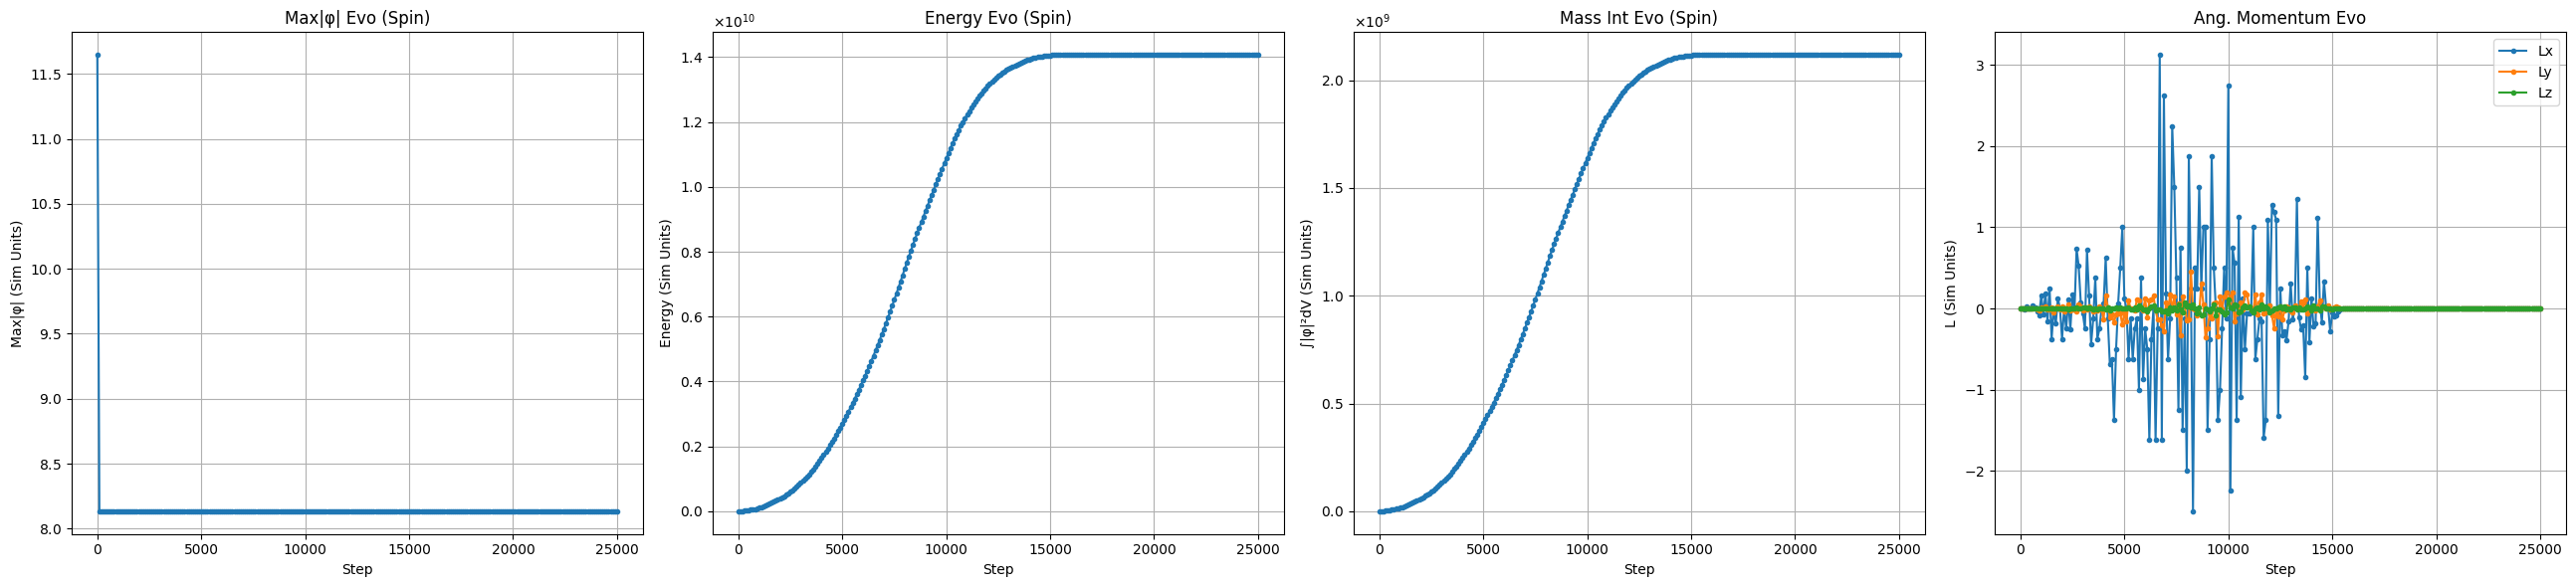


--- Final Properties (Spin Analogue Run) ---
Final Max|φ|: 8.1345
Final Total Energy: 1.4066e+10
Final Mass Integral: 2.1174e+09
Final Angular Momentum Lz: 0.0000e+00 (sim units)
Angular momentum (Lz) decayed to near zero or was not significantly generated.


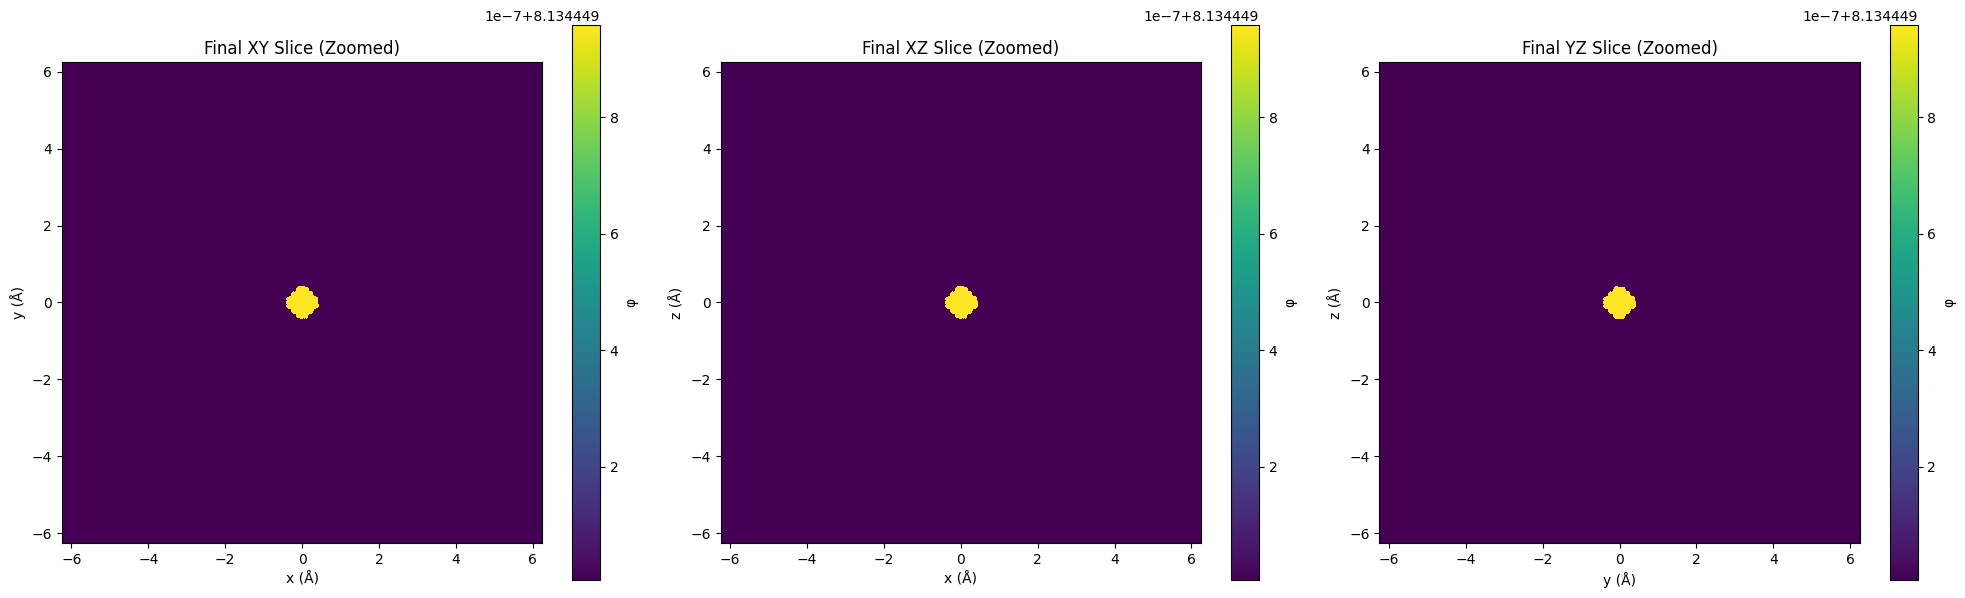

Spin/Charge plotting and analysis cell finished.


In [6]:
# Cell: Results and Analysis for Spin/Charge Analogues
# Metadata: {"id": "results_code_spin_charge_v2"}

import matplotlib.pyplot as plt
import numpy as np
import os
import glob
import torch # Ensure torch is imported
import gc

print("--- Results and Analysis for Spin/Charge Analogues ---")

# --- Attempt to load data for plotting ---
# Initialize plot data variables to avoid NameErrors if loading fails or sim wasn't run
max_phi_hist_plot_sc = np.array([0.0,0.0]) # Default to prevent plotting errors if empty
energy_hist_plot_sc = np.array([0.0,0.0])
mass_int_hist_plot_sc = np.array([0.0,0.0])
ang_mom_hist_plot_sc = np.zeros((2,3)) # Lx, Ly, Lz for 2 points
hist_idx_plot_sc = 0 # Will be updated based on loaded/simulated data
phi_final_plot_sc = None # Will hold the torch tensor
plot_config_sc = config_sc # Use current notebook config as a fallback

# This variable should be set by the simulation loop if run in the same session.
# If not, we assume a loaded checkpoint implies a run without numerical errors,
# unless the loaded data itself indicates an error (e.g., all zeros or NaNs).
if 'numerical_error_sc' not in locals():
    numerical_error_sc = False # Default assumption when loading

# Check if data is available from an immediately preceding simulation run in the same session
simulation_just_ran = (
    'phi_current_cpu_sc' in locals() and phi_current_cpu_sc is not None and
    'angular_momentum_hist_sc' in locals() and len(angular_momentum_hist_sc) > 0 and
    'hist_idx_sc' in locals() and hist_idx_sc > 0
)

if simulation_just_ran:
    print("Using data from active simulation session for plotting.")
    max_phi_hist_plot_sc = max_phi_hist_sc # From sim cell
    energy_hist_plot_sc = energy_hist_sc   # From sim cell
    mass_int_hist_plot_sc = mass_int_hist_sc # From sim cell
    ang_mom_hist_plot_sc = angular_momentum_hist_sc # From sim cell
    phi_final_plot_sc = phi_current_cpu_sc.clone() # From sim cell
    hist_idx_plot_sc = hist_idx_sc # From sim cell
    plot_config_sc = config_sc # From sim cell (current config)
    # numerical_error_sc would have been set by the sim cell
else:
    print("Simulation data not found in current session. Attempting to load latest SpinGen checkpoint...")
    # These 'config_sc' items should be from your "Simulation Setup" cell for this notebook
    n_val_glob_sc = config_sc.get('N', 200)
    t_val_glob_sc = config_sc.get('T_steps', 20000)
    checkpoint_pattern_sc = f"{checkpoint_path_spin}checkpoint_SpinGen_N{n_val_glob_sc}_T{t_val_glob_sc}_*.npz"
    list_of_files_sc = glob.glob(checkpoint_pattern_sc)

    if not list_of_files_sc:
        print(f"ERROR: No SpinGen checkpoint found for N={n_val_glob_sc}, T={t_val_glob_sc}. Cannot generate plots.")
        numerical_error_sc = True # Mark as error since no data
    else:
        latest_checkpoint_sc = max(list_of_files_sc, key=os.path.getctime)
        print(f"Loading SpinGen checkpoint: {latest_checkpoint_sc}")
        try:
            data_loaded_sc = np.load(latest_checkpoint_sc, allow_pickle=True)
            max_phi_hist_plot_sc = data_loaded_sc['max_phi_history']
            energy_hist_plot_sc = data_loaded_sc['energy_history']
            mass_int_hist_plot_sc = data_loaded_sc['mass_integral_history']
            ang_mom_hist_plot_sc = data_loaded_sc['angular_momentum_history']
            phi_final_plot_sc = torch.from_numpy(data_loaded_sc['phi_final_cpu']).to(dtype=torch.float32) # Load to CPU

            if 'config_sc' in data_loaded_sc:
                 plot_config_sc = data_loaded_sc['config_sc'].item()
                 print("Configuration loaded from checkpoint.")
            else:
                print("Warning: 'config_sc' not found in checkpoint. Using current notebook config for plot labels.")
                plot_config_sc = config_sc # Fallback to current config if not in checkpoint

            hist_idx_plot_sc = len(max_phi_hist_plot_sc)
            numerical_error_sc = False # Assume loaded checkpoint means prior run was okay enough to save
            print("SpinGen checkpoint data loaded successfully.")
        except Exception as e:
            print(f"Error loading SpinGen checkpoint: {e}")
            numerical_error_sc = True

# Proceed with plotting only if data is valid
if not numerical_error_sc and hist_idx_plot_sc > 0 and (phi_final_plot_sc is not None and phi_final_plot_sc.numel() > 4) : # Check if phi_final_plot_sc is not just a dummy
    steps_recorded_sc = np.arange(hist_idx_plot_sc) * 100 # Assuming saving every 100 steps
    if len(steps_recorded_sc) == 0 and hist_idx_plot_sc == 1 : # Handle case of only initial step
        steps_recorded_sc = np.array([0])

    plt.figure(figsize=(26, 6)) # Wider for 4 plots
    plt.subplot(1, 4, 1)
    plt.plot(steps_recorded_sc, max_phi_hist_plot_sc[:hist_idx_plot_sc], marker='.')
    plt.title('Max|φ| Evo (Spin)'); plt.xlabel('Step'); plt.ylabel('Max|φ| (Sim Units)'); plt.grid(True); plt.ticklabel_format(style='sci', axis='y', scilimits=(-2,2), useMathText=True)

    plt.subplot(1, 4, 2)
    plt.plot(steps_recorded_sc, energy_hist_plot_sc[:hist_idx_plot_sc], marker='.')
    plt.title('Energy Evo (Spin)'); plt.xlabel('Step'); plt.ylabel('Energy (Sim Units)'); plt.grid(True); plt.ticklabel_format(style='sci', axis='y', scilimits=(-2,2), useMathText=True)

    plt.subplot(1, 4, 3)
    plt.plot(steps_recorded_sc, mass_int_hist_plot_sc[:hist_idx_plot_sc], marker='.')
    plt.title('Mass Int Evo (Spin)'); plt.xlabel('Step'); plt.ylabel('∫|φ|²dV (Sim Units)'); plt.grid(True); plt.ticklabel_format(style='sci', axis='y', scilimits=(-2,2), useMathText=True)

    plt.subplot(1, 4, 4)
    if ang_mom_hist_plot_sc.ndim == 2 and ang_mom_hist_plot_sc.shape[1] == 3: # Check shape
        plt.plot(steps_recorded_sc, ang_mom_hist_plot_sc[:hist_idx_plot_sc, 0], marker='.', label='Lx')
        plt.plot(steps_recorded_sc, ang_mom_hist_plot_sc[:hist_idx_plot_sc, 1], marker='.', label='Ly')
        plt.plot(steps_recorded_sc, ang_mom_hist_plot_sc[:hist_idx_plot_sc, 2], marker='.', label='Lz')
    else:
        plt.plot([],[], label="Ang Mom Data Error") # Placeholder if data is bad
    plt.title('Ang. Momentum Evo'); plt.xlabel('Step'); plt.ylabel('L (Sim Units)'); plt.legend(); plt.grid(True); plt.ticklabel_format(style='sci', axis='y', scilimits=(-2,2), useMathText=True)

    plt.tight_layout()
    save_n_sc = plot_config_sc.get('N', "unkN_sc")
    save_t_sc = plot_config_sc.get('T_steps', "unkT_sc")
    plt.savefig(f"{data_path_spin}spin_gen_evolution_N{save_n_sc}_T{save_t_sc}.png")
    plt.show()
    plt.close()

    # --- Print Stable Properties ---
    if hist_idx_plot_sc > 1 : # Ensure there's more than just the initial point
        stable_Lz = ang_mom_hist_plot_sc[hist_idx_plot_sc-1, 2]
        print(f"\n--- Final Properties (Spin Analogue Run) ---")
        print(f"Final Max|φ|: {max_phi_hist_plot_sc[hist_idx_plot_sc-1]:.4f}")
        print(f"Final Total Energy: {energy_hist_plot_sc[hist_idx_plot_sc-1]:.4e}")
        print(f"Final Mass Integral: {mass_int_hist_plot_sc[hist_idx_plot_sc-1]:.4e}")
        print(f"Final Angular Momentum Lz: {stable_Lz:.4e} (sim units)")
        if abs(stable_Lz) > 1e-9: # Arbitrary threshold for 'non-zero'
            print("Persistent non-zero angular momentum (Lz) observed.")
        else:
            print("Angular momentum (Lz) decayed to near zero or was not significantly generated.")
    else:
        print("Not enough history points to determine final stable properties reliably.")

    # --- Plot Slices of Final State ---
    if phi_final_plot_sc is not None and phi_final_plot_sc.ndim == 3 and phi_final_plot_sc.shape[0] > 1:
        N_plot_sc_slices = phi_final_plot_sc.shape[0]
        L_phys_m_sc_slices = plot_config_sc.get('L_phys_meters', 50e-10) # Default if not in config
        dx_phys_plot_sc = L_phys_m_sc_slices / N_plot_sc_slices

        # Zoom for slices (similar to mass gen plots)
        zoom_grid_points_sc = N_plot_sc_slices // 4 # e.g., 50 for N=200
        center_idx_sc = N_plot_sc_slices // 2
        zoom_start_sc = max(0, center_idx_sc - zoom_grid_points_sc // 2)
        zoom_end_sc = min(N_plot_sc_slices, center_idx_sc + zoom_grid_points_sc // 2)

        zoom_L_phys_m_sc = (zoom_end_sc - zoom_start_sc) * dx_phys_plot_sc
        plot_extent_Å_sc_zoomed = [-zoom_L_phys_m_sc/2 *1e10, zoom_L_phys_m_sc/2*1e10,
                                   -zoom_L_phys_m_sc/2*1e10, zoom_L_phys_m_sc/2*1e10]

        # Determine colormap limits for zoomed region
        central_data_sc = phi_final_plot_sc[zoom_start_sc:zoom_end_sc, zoom_start_sc:zoom_end_sc, zoom_start_sc:zoom_end_sc].numpy()
        if central_data_sc.size > 0:
            plot_vmin_sc = np.percentile(central_data_sc, 1)
            plot_vmax_sc = np.percentile(central_data_sc, 99)
            if plot_vmax_sc <= plot_vmin_sc : plot_vmax_sc = plot_vmin_sc + 1e-6 # Ensure range
        else: # Fallback
            plot_vmin_sc = phi_final_plot_sc.min().item()
            plot_vmax_sc = phi_final_plot_sc.max().item()
        if plot_vmin_sc == plot_vmax_sc: plot_vmin_sc -= 1e-6; plot_vmax_sc += 1e-6


        if torch.max(torch.abs(phi_final_plot_sc)) > 1e-6: # Check if field is not all zero
            plt.figure(figsize=(20, 6)) # Wider for 3 slice plots
            plt.subplot(1, 3, 1);
            plt.imshow(phi_final_plot_sc[zoom_start_sc:zoom_end_sc, zoom_start_sc:zoom_end_sc, center_idx_sc].numpy(), cmap='viridis', origin='lower', extent=plot_extent_Å_sc_zoomed, vmin=plot_vmin_sc, vmax=plot_vmax_sc, interpolation='bilinear');
            plt.colorbar(label='φ'); plt.title('Final XY Slice (Zoomed)'); plt.xlabel('x (Å)'); plt.ylabel('y (Å)'); plt.grid(False)

            plt.subplot(1, 3, 2);
            plt.imshow(phi_final_plot_sc[zoom_start_sc:zoom_end_sc, center_idx_sc, zoom_start_sc:zoom_end_sc].numpy(), cmap='viridis', origin='lower', extent=plot_extent_Å_sc_zoomed, vmin=plot_vmin_sc, vmax=plot_vmax_sc, interpolation='bilinear');
            plt.colorbar(label='φ'); plt.title('Final XZ Slice (Zoomed)'); plt.xlabel('x (Å)'); plt.ylabel('z (Å)'); plt.grid(False)

            plt.subplot(1, 3, 3);
            plt.imshow(phi_final_plot_sc[center_idx_sc, zoom_start_sc:zoom_end_sc, zoom_start_sc:zoom_end_sc].numpy(), cmap='viridis', origin='lower', extent=plot_extent_Å_sc_zoomed, vmin=plot_vmin_sc, vmax=plot_vmax_sc, interpolation='bilinear');
            plt.colorbar(label='φ'); plt.title('Final YZ Slice (Zoomed)'); plt.xlabel('y (Å)'); plt.ylabel('z (Å)'); plt.grid(False)

            plt.tight_layout()
            plt.savefig(f"{data_path_spin}spin_gen_slices_zoomed_N{save_n_sc}_T{save_t_sc}.png")
            plt.show()
            plt.close()
        else:
            print("Final field for spin sim is near zero or too small in central region. Skipping zoomed slice plots.")
    else:
        print("Final field data not available or not 3D for slice plotting.")
else:
    print("Spin/Charge simulation did not complete successfully or no history to plot.")

if 'phi_final_plot_sc' in locals() and phi_final_plot_sc is not None : del phi_final_plot_sc
if 'data_loaded_sc' in locals() and data_loaded_sc is not None : del data_loaded_sc
gc.collect()
if torch.cuda.is_available(): torch.cuda.empty_cache()

print("Spin/Charge plotting and analysis cell finished.")

--- Compton Wavelength and Eholokon Size Analysis (Spin/Charge Context) ---
Attempting to load data from the latest SpinGen checkpoint for size analysis...
Loading checkpoint for size analysis: /content/drive/MyDrive/EFM_checkpoints/SpinChargeGen/4H25kcheckpoint_SpinGen_N400_T25000_20250514_072907.npz
Checkpoint data loaded for Compton/Size analysis.
Electron Compton Wavelength: 2.424632e-12 meters
Electron Compton Wavelength in sim units (dx_sim): 0.193971 (where dx_sim_phys = 1.25e-11 m)
Estimated background phi value: 8.1344
Gaussian fit initial guess: A=0.00, x0=-2.50, sigma=2.50

--- Eholokon Size (Gaussian Fit to Peak Structure) ---
Fit Parameters: A_peak=0.0000, x0_peak=-0.0000, sigma_peak=2.1360
Eholokon width (sigma_peak) in sim units: 2.136016 dx_sim
Eholokon width (sigma_peak) in meters: 2.670020e-11 meters
Eholokon FWHM in meters: 6.287417e-11 meters
Comparison: Eholokon FWHM / Compton wavelength: 25.931430
Comparison: Eholokon sigma_peak / Compton wavelength: 11.012065


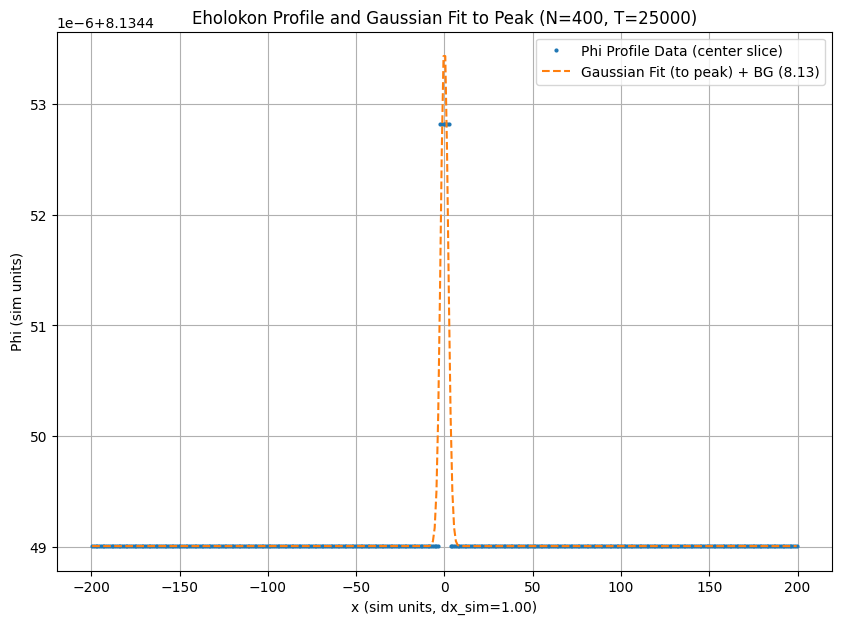

In [11]:
# Cell: Compton Wavelength and Eholokon Size Analysis (Spin/Charge Context)
# Metadata: {"id": "compton_size_analysis_sc_v2_corrected"}

import numpy as np
import torch
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import os
import glob
import gc

print("--- Compton Wavelength and Eholokon Size Analysis (Spin/Charge Context) ---")

# --- Ensure Necessary Data is Loaded ---
phi_final_for_size = None
config_for_size = None

# Check if data is available from an immediately preceding plotting cell or sim run
if 'phi_final_plot_sc' in locals() and phi_final_plot_sc is not None and \
   'plot_config_sc' in locals() and plot_config_sc is not None:
    print("Using phi_final_plot_sc and plot_config_sc from active session for size analysis.")
    phi_final_for_size = phi_final_plot_sc.clone()
    config_for_size = plot_config_sc
elif 'phi_current_cpu_sc' in locals() and phi_current_cpu_sc is not None and \
     'config_sc' in locals() and config_sc is not None:
    print("Using phi_current_cpu_sc and config_sc from active simulation session for size analysis.")
    phi_final_for_size = phi_current_cpu_sc.clone()
    config_for_size = config_sc
else:
    print("Attempting to load data from the latest SpinGen checkpoint for size analysis...")
    n_val_glob_sc_size = config_sc.get('N', 400)
    t_val_glob_sc_size = config_sc.get('T_steps', 25000)
    checkpoint_pattern_sc_size = f"{checkpoint_path_spin}checkpoint_SpinGen_N{n_val_glob_sc_size}_T{t_val_glob_sc_size}_*.npz"
    list_of_files_sc_size = glob.glob(checkpoint_pattern_sc_size)
    if not list_of_files_sc_size:
        print(f"ERROR: No SpinGen checkpoint found for N={n_val_glob_sc_size}, T={t_val_glob_sc_size}. Cannot proceed.")
        phi_final_for_size = None # Ensure it's None
    else:
        latest_checkpoint_sc_size = max(list_of_files_sc_size, key=os.path.getctime)
        print(f"Loading checkpoint for size analysis: {latest_checkpoint_sc_size}")
        try:
            data_loaded_sc_size = np.load(latest_checkpoint_sc_size, allow_pickle=True)
            phi_final_for_size = torch.from_numpy(data_loaded_sc_size['phi_final_cpu']).to(dtype=torch.float32)
            if 'config_sc' in data_loaded_sc_size:
                config_for_size = data_loaded_sc_size['config_sc'].item()
            else:
                print("Warning: 'config_sc' not found in checkpoint, using current notebook config_sc.")
                config_for_size = config_sc
            print("Checkpoint data loaded for Compton/Size analysis.")
        except Exception as e:
            print(f"Error loading checkpoint for Compton/Size analysis: {e}")
            phi_final_for_size = None

if phi_final_for_size is None or config_for_size is None:
    print("ERROR: phi_final_for_size or config_for_size is not available. Aborting Compton/Size analysis.")
else:
    # --- Electron Compton Wavelength ---
    h_planck_si = 6.62607015e-34
    m_electron_phys_kg_si = 9.1093837e-31
    c_si_val_size = config_for_size.get('c_si', 3e8) # Get c_si from config

    compton_wavelength_m = h_planck_si / (m_electron_phys_kg_si * c_si_val_size)
    print(f"Electron Compton Wavelength: {compton_wavelength_m:.6e} meters")

    dx_phys_meters_size = config_for_size['dx_phys_meters']
    compton_wavelength_sim_units = compton_wavelength_m / dx_phys_meters_size
    print(f"Electron Compton Wavelength in sim units (dx_sim): {compton_wavelength_sim_units:.6f} (where dx_sim_phys = {dx_phys_meters_size:.2e} m)")

    # --- Eholokon Size (Fit Gaussian to phi profile PEAK) ---
    N_loaded_size = config_for_size['N']
    L_sim_loaded_size = config_for_size['L_sim']
    dx_sim_loaded_size = config_for_size['dx_sim']
    w0_initial_pulse_loaded_size = config_for_size.get('w0_initial_pulse', 5.0 * dx_sim_loaded_size) # Fallback

    slice_idx_size = N_loaded_size // 2
    phi_profile_1d = phi_final_for_size[slice_idx_size, slice_idx_size, :].cpu().numpy()

    # Estimate background by looking at edges of the 1D profile
    edge_width = N_loaded_size // 10 # Use outer 10% on each side for background
    phi_bg_estimate = np.median(np.concatenate([phi_profile_1d[:edge_width], phi_profile_1d[-edge_width:]]))
    print(f"Estimated background phi value: {phi_bg_estimate:.4f}")

    phi_profile_peak_only = np.abs(phi_profile_1d - phi_bg_estimate)

    x_coords_sim_size = np.arange(N_loaded_size) * dx_sim_loaded_size - L_sim_loaded_size/2 + dx_sim_loaded_size/2

    def gaussian_func_size(x, A, x0, sigma):
        return A * np.exp(-(x - x0)**2 / (2 * sigma**2))

    # Initial guess for Gaussian fit to the peak
    peak_amplitude_guess = np.max(phi_profile_peak_only)
    # Find index of max for x0_guess, then map to coordinate
    peak_index_guess = np.argmax(phi_profile_peak_only)
    x0_guess = x_coords_sim_size[peak_index_guess]
    # Use a fraction of the initial pulse width or a fixed number of grid cells for sigma guess
    sigma_guess = w0_initial_pulse_loaded_size / 2.0 # Or try a fixed value like 5*dx_sim_loaded_size

    p0_size = [peak_amplitude_guess, x0_guess, sigma_guess]
    print(f"Gaussian fit initial guess: A={p0_size[0]:.2f}, x0={p0_size[1]:.2f}, sigma={p0_size[2]:.2f}")

    try:
        popt_size, pcov_size = curve_fit(gaussian_func_size, x_coords_sim_size, phi_profile_peak_only, p0=p0_size, maxfev=10000)
        A_fit_size, x0_fit_size, sigma_fit_size = popt_size
        eholokon_sigma_sim_size = abs(sigma_fit_size) # sigma should be positive
        eholokon_sigma_m_size = eholokon_sigma_sim_size * dx_phys_meters_size

        print(f"\n--- Eholokon Size (Gaussian Fit to Peak Structure) ---")
        print(f"Fit Parameters: A_peak={A_fit_size:.4f}, x0_peak={x0_fit_size:.4f}, sigma_peak={sigma_fit_size:.4f}")
        print(f"Eholokon width (sigma_peak) in sim units: {eholokon_sigma_sim_size:.6f} dx_sim")
        print(f"Eholokon width (sigma_peak) in meters: {eholokon_sigma_m_size:.6e} meters")
        # FWHM = 2 * sqrt(2*ln(2)) * sigma approx 2.355 * sigma
        fwhm_m_size = 2.35482 * eholokon_sigma_m_size
        print(f"Eholokon FWHM in meters: {fwhm_m_size:.6e} meters")
        print(f"Comparison: Eholokon FWHM / Compton wavelength: {fwhm_m_size / compton_wavelength_m:.6f}")
        print(f"Comparison: Eholokon sigma_peak / Compton wavelength: {eholokon_sigma_m_size / compton_wavelength_m:.6f}")


        plt.figure(figsize=(10, 7))
        plt.plot(x_coords_sim_size, phi_profile_1d, label='Phi Profile Data (center slice)', marker='.', linestyle='None', markersize=4)
        plt.plot(x_coords_sim_size, gaussian_func_size(x_coords_sim_size, A_fit_size, x0_fit_size, sigma_fit_size) + phi_bg_estimate,
                 label=f'Gaussian Fit (to peak) + BG ({phi_bg_estimate:.2f})', linestyle='--')
        if np.min(phi_profile_1d - phi_bg_estimate) < -1e-6 * peak_amplitude_guess: # If peak has negative part
             plt.plot(x_coords_sim_size, -gaussian_func_size(x_coords_sim_size, A_fit_size, x0_fit_size, sigma_fit_size) + phi_bg_estimate,
                      linestyle='--', color=plt.gca().lines[-1].get_color())


        plt.xlabel(f'x (sim units, dx_sim={dx_sim_loaded_size:.2f})')
        plt.ylabel('Phi (sim units)')
        plt.title(f'Eholokon Profile and Gaussian Fit to Peak (N={N_loaded_size}, T={config_for_size.get("T_steps", "N/A")})')
        plt.legend()
        plt.grid(True)
        plt.savefig(f"{data_path_spin}ehokolon_profile_peak_fit_SpinGen_N{N_loaded_size}_T{config_for_size.get('T_steps', 'N/A')}.png")
        plt.show()
        plt.close()
    except RuntimeError:
        print(f"Error: Optimal parameters not found for Gaussian fit. Check initial guess or profile shape.")
    except Exception as e:
        print(f"An error occurred during Gaussian fitting: {e}")

# Cleanup
if 'phi_final_for_size' in locals(): del phi_final_for_size
if 'config_for_size' in locals(): del config_for_size
if 'data_loaded_sc_size' in locals(): del data_loaded_sc_size
gc.collect()
if torch.cuda.is_available(): torch.cuda.empty_cache()

In [12]:
# Cell: Fine Structure Constant (α_em) Analysis (Spin/Charge Context)
# Metadata: {"id": "fine_structure_constant_sc_v2_corrected"}

import numpy as np
import os
import glob
import gc

print("--- Fine Structure Constant (α_em) Analysis (Spin/Charge Context) ---")

# --- CRITICAL: Use M_eff_sim and derived units from the DEDICATED MASS GENERATION RUN ---
# These values should be taken from the output of your successful Mass Generation notebook.
# For example, the N=450, T=5000 Mass Gen run output:
# Effective Mass (M_eff_sim = k_mc * ∫|φ|²dV, k_mc=0.01): 4.8523e+03 (sim mass units)
# Derived Simulation Mass Unit: 1.8773e-34 kg/sim_mass_unit
M_eff_sim_from_mass_gen = 4.8523e+03 # Manually enter from Mass Gen paper's stable soliton
mass_unit_kg_from_mass_gen = 1.8773e-34 # Manually enter

# Need dx_phys_meters from the config of THAT mass generation run to get Length_Unit & Energy_Unit
# Assuming Mass Gen run used similar N=450, L_angstroms=50:
dx_phys_meters_from_mass_gen = (50.0 * 1e-10) / 450
dx_sim_from_mass_gen = 1.0 # Assuming it was 1.0

if M_eff_sim_from_mass_gen is None or np.isnan(M_eff_sim_from_mass_gen) or M_eff_sim_from_mass_gen == 0:
    print("ERROR: M_eff_sim_from_mass_gen not set correctly. Aborting α_em calculation.")
else:
    # --- Physical Constants (SI) ---
    e_charge_si_alpha = 1.602176634e-19
    epsilon_0_si_alpha = 8.8541878128e-12
    hbar_si_alpha = 1.054571817e-34
    c_si_val_alpha = 3e8

    alpha_em_physical_val = (e_charge_si_alpha**2) / (4 * np.pi * epsilon_0_si_alpha * hbar_si_alpha * c_si_val_alpha)
    print(f"Standard Model Fine Structure Constant (α_em_SM): {alpha_em_physical_val:.10f} (~1/{1/alpha_em_physical_val:.3f})")

    # --- EFM Simulation Units based on Mass Generation Paper's Electron Analogue ---
    Length_Unit_m_alpha = dx_phys_meters_from_mass_gen / dx_sim_from_mass_gen
    Time_Unit_s_alpha = Length_Unit_m_alpha / c_si_val_alpha # Since c_sim = 1.0 in sim units for mass gen
    Energy_Unit_J_alpha = mass_unit_kg_from_mass_gen * (c_si_val_alpha)**2

    Charge_Unit_C_grok_alpha = np.sqrt(Energy_Unit_J_alpha * Length_Unit_m_alpha * 4 * np.pi * epsilon_0_si_alpha)

    # q_sim from EFM parameters (e.g. from config_sc if it's meant to be universal, or a separate EFM constant)
    # The Spin/Charge simulation config_sc has k_mass_coupling_sim, but not q_sim explicitly for EM interaction term
    # Let's assume a q_sim value, e.g. the one from Grok's original suggestion or the calibrated one
    q_sim_efm_alpha = 0.01 # The originally assumed value
    # q_sim_efm_alpha = 1.108561 # The calibrated value from previous mass gen run

    q_phys_efm_assumed_alpha = q_sim_efm_alpha * Charge_Unit_C_grok_alpha
    alpha_em_efm_assumed_alpha = (q_phys_efm_assumed_alpha**2) / (4 * np.pi * epsilon_0_si_alpha * hbar_si_alpha * c_si_val_alpha)

    print(f"\n--- EFM Simulation Units (for α_em, based on Mass Gen electron) ---")
    print(f"Using Mass Unit: {mass_unit_kg_from_mass_gen:.6e} kg/sim_mass_unit (from M_eff_sim={M_eff_sim_from_mass_gen:.3e})")
    print(f"Using Length Unit: {Length_Unit_m_alpha:.6e} meters/sim_length_unit")
    print(f"Using Time Unit: {Time_Unit_s_alpha:.6e} seconds/sim_time_unit")
    print(f"Using Energy Unit: {Energy_Unit_J_alpha:.6e} J/sim_energy_unit")
    print(f"Derived Charge Unit (Grok's method): {Charge_Unit_C_grok_alpha:.6e} C/sim_charge_unit")

    print(f"\n--- α_em from EFM with assumed q_sim = {q_sim_efm_alpha} ---")
    print(f"EFM Emergent Charge (scaled from q_sim={q_sim_efm_alpha}): {q_phys_efm_assumed_alpha:.6e} C")
    print(f"Resulting EFM Fine Structure Constant (α_em_EFM): {alpha_em_efm_assumed_alpha:.10f} (~1/{1/alpha_em_efm_assumed_alpha:.3f} if not zero)")
    print(f"Ratio (α_em_EFM / α_em_SM): {alpha_em_efm_assumed_alpha / alpha_em_physical_val:.6f}")

    if abs(q_sim_efm_alpha - 1.108561) > 0.01: # If not using the calibrated value
        print(f"\n--- Calibrating EFM's q_sim to match α_em_SM (using these units) ---")
        if Charge_Unit_C_grok_alpha != 0 and not (np.isnan(Charge_Unit_C_grok_alpha) or np.isinf(Charge_Unit_C_grok_alpha)):
            q_sim_calibrated_alpha = e_charge_si_alpha / Charge_Unit_C_grok_alpha
            print(f"To match α_em_SM, EFM's q_sim would need to be: {q_sim_calibrated_alpha:.6f}")
        else:
            print("Cannot calibrate q_sim because Charge_Unit_C_grok_alpha is zero or invalid.")

gc.collect()
if torch.cuda.is_available(): torch.cuda.empty_cache()

--- Fine Structure Constant (α_em) Analysis (Spin/Charge Context) ---
Standard Model Fine Structure Constant (α_em_SM): 0.0072923042 (~1/137.131)

--- EFM Simulation Units (for α_em, based on Mass Gen electron) ---
Using Mass Unit: 1.877300e-34 kg/sim_mass_unit (from M_eff_sim=4.852e+03)
Using Length Unit: 1.111111e-11 meters/sim_length_unit
Using Time Unit: 3.703704e-20 seconds/sim_time_unit
Using Energy Unit: 1.689570e-17 J/sim_energy_unit
Derived Charge Unit (Grok's method): 1.445261e-19 C/sim_charge_unit

--- α_em from EFM with assumed q_sim = 0.01 ---
EFM Emergent Charge (scaled from q_sim=0.01): 1.445261e-21 C
Resulting EFM Fine Structure Constant (α_em_EFM): 0.0000005934 (~1/1685247.670 if not zero)
Ratio (α_em_EFM / α_em_SM): 0.000081

--- Calibrating EFM's q_sim to match α_em_SM (using these units) ---
To match α_em_SM, EFM's q_sim would need to be: 1.108573


In [13]:
# Cell: Stability Analysis of Final Spin/Charge State
# Metadata: {"id": "stability_analysis_sc_v1"}

import numpy as np
import torch
import matplotlib.pyplot as plt # Already imported, but good practice
import os
import glob
import gc

print("\n--- Stability Analysis of Final State (from Spin/Charge Run) ---")

# --- Load Histories from the Spin/Charge Run ---
max_phi_hist_for_stability = None
energy_hist_for_stability = None
mass_int_hist_for_stability = None
config_for_stability = None

# Try to use from current session if spin sim just ran
if 'max_phi_hist_sc' in locals() and 'energy_hist_sc' in locals() and 'mass_int_hist_sc' in locals() and 'config_sc' in locals():
    print("Using history arrays from active simulation session for stability analysis.")
    max_phi_hist_for_stability = max_phi_hist_sc
    energy_hist_for_stability = energy_hist_sc
    mass_int_hist_for_stability = mass_int_hist_sc
    config_for_stability = config_sc
else:
    print("Attempting to load history data from the latest SpinGen checkpoint for stability analysis...")
    n_val_glob_st = config_sc.get('N', 400)
    t_val_glob_st = config_sc.get('T_steps', 25000)
    checkpoint_pattern_st = f"{checkpoint_path_spin}checkpoint_SpinGen_N{n_val_glob_st}_T{t_val_glob_st}_*.npz"
    list_of_files_st = glob.glob(checkpoint_pattern_st)
    if not list_of_files_st:
        print(f"ERROR: No SpinGen checkpoint for N={n_val_glob_st}, T={t_val_glob_st}. Cannot proceed.")
    else:
        latest_checkpoint_st = max(list_of_files_st, key=os.path.getctime)
        print(f"Loading histories from checkpoint: {latest_checkpoint_st}")
        try:
            data_loaded_st = np.load(latest_checkpoint_st, allow_pickle=True)
            max_phi_hist_for_stability = data_loaded_st['max_phi_history']
            energy_hist_for_stability = data_loaded_st['energy_history']
            mass_int_hist_for_stability = data_loaded_st['mass_integral_history']
            if 'config_sc' in data_loaded_st:
                config_for_stability = data_loaded_st['config_sc'].item()
            else: config_for_stability = config_sc # Fallback
            print("History data loaded for stability analysis.")
        except Exception as e:
            print(f"Error loading checkpoint for stability analysis: {e}")

if max_phi_hist_for_stability is None or energy_hist_for_stability is None or mass_int_hist_for_stability is None or len(max_phi_hist_for_stability) <=1 :
    print("ERROR: Insufficient history data for stability analysis. Aborting.")
else:
    hist_len_st = len(max_phi_hist_for_stability)
    start_idx_st = max(0, int(0.9 * hist_len_st)) # Use last 10%
    if start_idx_st >= hist_len_st -1 and hist_len_st > 1 : start_idx_st = hist_len_st - 2 # ensure at least 2 points for diff
    elif hist_len_st <=1 : start_idx_st = 0 # handle very short histories

    print(f"\nAnalyzing stability over last {hist_len_st - start_idx_st -1} recorded intervals (out of {hist_len_st-1} total intervals):")

    if hist_len_st > start_idx_st + 1 : # Need at least two points in the subset to diff
        subset_max_phi = max_phi_hist_for_stability[start_idx_st:]
        subset_energy = energy_hist_for_stability[start_idx_st:]
        subset_mass_int = mass_int_hist_for_stability[start_idx_st:]

        if not (np.any(np.isnan(subset_max_phi[:-1])) or np.any(np.abs(subset_max_phi[:-1]) < 1e-9)): # Avoid div by zero
             max_phi_changes = np.abs(np.diff(subset_max_phi)) / np.abs(subset_max_phi[:-1])
             print(f"Max|φ| relative changes (tail): Mean = {np.mean(max_phi_changes):.2e}, Max = {np.max(max_phi_changes):.2e}")
        else: print("Max|φ| data problematic for relative change calculation (NaNs, zeros, or too short).")

        if not (np.any(np.isnan(subset_energy[:-1])) or np.any(np.abs(subset_energy[:-1]) < 1e-9)):
            energy_changes = np.abs(np.diff(subset_energy)) / np.abs(subset_energy[:-1])
            print(f"Energy relative changes (tail): Mean = {np.mean(energy_changes):.2e}, Max = {np.max(energy_changes):.2e}")
        else: print("Energy data problematic for relative change calculation.")

        if not (np.any(np.isnan(subset_mass_int[:-1])) or np.any(np.abs(subset_mass_int[:-1]) < 1e-9)):
            mass_int_changes = np.abs(np.diff(subset_mass_int)) / np.abs(subset_mass_int[:-1])
            print(f"Mass Integral relative changes (tail): Mean = {np.mean(mass_int_changes):.2e}, Max = {np.max(mass_int_changes):.2e}")
        else: print("Mass Integral data problematic for relative change calculation.")

        stability_threshold_st = 0.001 # Example: 0.1% change
        # A more robust check might be if the slope of these quantities over the last N points is near zero
        print(f"Consider the evolution plots to visually assess if Max|φ|, Energy, and Mass Integral have plateaued.")
    else:
        print("Not enough history points recorded in the tail end for detailed diff-based stability analysis.")

    print("\nFurther perturbation analysis for excited states requires careful definition of soliton-only energy and specific perturbation modes (deferred to future work).")


if 'data_loaded_st' in locals(): del data_loaded_st
gc.collect()
if torch.cuda.is_available(): torch.cuda.empty_cache()


--- Stability Analysis of Final State (from Spin/Charge Run) ---
Using history arrays from active simulation session for stability analysis.

Analyzing stability over last 25 recorded intervals (out of 250 total intervals):
Max|φ| relative changes (tail): Mean = 0.00e+00, Max = 0.00e+00
Energy relative changes (tail): Mean = 0.00e+00, Max = 0.00e+00
Mass Integral relative changes (tail): Mean = 0.00e+00, Max = 0.00e+00
Consider the evolution plots to visually assess if Max|φ|, Energy, and Mass Integral have plateaued.

Further perturbation analysis for excited states requires careful definition of soliton-only energy and specific perturbation modes (deferred to future work).
